## 0) Utilities

In [1]:
## General librairies
import pandas as pd
import numpy as np
import _pickle as pickle
import matplotlib.pyplot as plt
import random
import sys
import time
from copy import deepcopy


## Cosine Distance
from scipy.spatial.distance import cosine


## Keras utilities
import keras
import tensorflow
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda,  Dense, Flatten,MaxPooling2D,Dropout, UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D
# from tensorflow.keras.engine.input_layer import Input
from keras.layers import merge
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle

## Sklearn utilities
#### Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#### Scores
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#### Feature transformations
import umap




## Removing some of the useless warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
## Some useful functions to ease the processings
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

def plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    x = list(range(len(acc)))
    plt.plot(x,acc)
    plt.plot(x,val_acc)
    
def cat_to_num(y):
    y1 = []
    for i in range(y.shape[0]):
        a = 0
        for j in range(y.shape[1]):
            a += j*y[i,j]
        y1.append(int(a))
    return y1

def generate_integer():
    
    ints = []
    
    while len(ints)<5:
        r = random.randint(0,63)
        if not(r in ints):
            ints.append(r)
    return ints

## 1) Meta Training

#### Neural Net Architecture

#### Loading and plotting the meta-learning set

In [ ]:
OT = pickle.load(open('miniImageNet_category_split_train_phase_train.pickle', 'rb'), encoding='latin1')

for i in range(5):
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    for j in range(5):
        fig.axes[j].get_xaxis().set_visible(False)
        fig.axes[j].get_yaxis().set_visible(False)
    ax1.imshow(OT['data'][600*i+1])
    ax2.imshow(OT['data'][600*i+2])    
    ax3.imshow(OT['data'][600*i+3])
    ax4.imshow(OT['data'][600*i+4])
    ax5.imshow(OT['data'][600*i+5])
    
Y_meta = OT['labels']
X_meta = OT['data']

y_meta = np_utils.to_categorical(Y_meta)
del OT

#### Setting up the training of the neural net on the meta learning set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.1, random_state=42)

###### First training of the model

In [ ]:
from keras.applications import densenet
model_transfert = densenet.DenseNet121(include_top=False,input_shape=(84,84,3), weights = None  )

inputs = model_transfert.input
outputs = model_transfert.output
outputs = GlobalAveragePooling2D(name='avg_pool')(outputs)
outputs = Dense(64, activation='softmax', name='fc64')(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
model.summary()


In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# model = resnet2(64)

# import resnet
# build = resnet.ResnetBuilder()
# model = build.build_resnet_18((3,84,84),64)

# model = ResNet(64)
# model = load( '2.densenet with augmentation', 'model')
# model = load( '2.resnet with augmentation 2nd step', 'model')


optimizer=SGD(lr=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# model.summary()

# batch_size = 32
# epochs = 150

batch_size = 64
epochs = 5

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save(history, '2.resnet with augmentation', 'results')
# save(model, '2.resnet with augmentation', 'model')
plot(history)

In [ ]:
save(model, '3.resnet18 with augmentation step 0.001', 'model')

###### Second training of the model

Do 5 epochs with big deformation, 5 with normal deformation again and 2 without augmenation
By the end of this step, the validation accuracy of the model should be around 0.67, you can stop it if it reaches this score

In [ ]:
model = load('2.resnet with augmentation', 'model')

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 90
epochs = 4

aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
                         width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
                         horizontal_flip=True, fill_mode="nearest")

# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
#                          width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
#                          horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)


# history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test))


score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save(history, '2.resnet with augmentation 2nd step', 'results')
save(model, '2.resnet with augmentation 2nd step', 'model')
plot(history)

In [ ]:
# model = load('2.resnet with augmentation', 'model')
save(model, '2.resnet with augmentation 2nd step', 'model')

###### Third training of the model

Using a different random state in order to use all the data available

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, random_state=43)

In [ ]:
# model = load('2.resnet with augmentation 2nd step', 'model')
# model = load('2.resnet with augmentation', 'model')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 64
epochs = 1

# aug = ImageDataGenerator(rotation_range=40, zoom_range=0.3,
#                          width_shift_range=0.4, height_shift_range=0.6, shear_range=0.3,
#                          horizontal_flip=True, fill_mode="nearest")

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# save(history, '2.resnet with augmentation 3rd step', 'results')
# save(model, '2.resnet with augmentation 3rd step', 'model')

## the current equivalent prétrained model is : '2.resnet2 with augmentation 2'
plot(history)

## 2) Experiments

###### Loading and merging the validation data

In [4]:
OT1 = pickle.load(open('miniImageNet_category_split_test.pickle', 'rb'), encoding='latin1')
OT2 = pickle.load(open('miniImageNet_category_split_val.pickle', 'rb'), encoding='latin1')

from copy import deepcopy
Y_val = deepcopy(OT2['labels'])
X_val = deepcopy(OT2['data'])

## Concatenating val and test datas in order to get more classes for experiment
for i in OT1['labels']:
    Y_val.append(i)
X_val = np.concatenate([X_val, OT1['data']], axis = 0)

## Restructuring the images into an array of size 64*600*84*84*3 to ease the acces to a given class
tab = []
for i in range(36):
    tab.append([])

for i in range(len(Y_val)):
    tab[Y_val[i]-64].append(X_val[i])

X = np.array(tab)

In [3]:
n = 5
k = 5


## A function in order to generate a random array of n distincts values between m and M
def choose_n_classes(n, m, M):
    tab = []
    while len(tab)<n:
        r = random.randint(m,M)
        if not(r in tab):
            tab.append(r)
    tab.sort()
    tab = np.array(tab)
    
    dico = {}
    for i in range(n):
        dico[tab[i]] = i
    
    return tab, dico


## A function to generate data ready for an experiment, tab and dico are here in order to repeat the experiment 
## on the same 5 classes, but with a different number of drawn sample in the class
def build_dataset(X, n,k,value = True, tab = True, dico = True):
    if value == True:
        tab, dico = choose_n_classes(n, 64,99)
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    print(dico)
    
    for elt in tab:
        ind, dico1 = choose_n_classes(k, 0, 600)
        ind1, dico2 = choose_n_classes(100, 0, 600)
        for i in range(600):
            if i in ind:
                x_train.append(X[elt-64,i])
                y_train.append(dico[elt])
#             elif i in ind1:
#                 x_test.append(X[elt-64,i])
#                 y_test.append(dico[elt])
            else:
                x_test.append(X[elt-64,i])
                y_test.append(dico[elt])
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test), tab, dico

Loading the pre-trained model for features extraction

The output layer should be the last batch_normalization of the previous model

In [5]:
# '2.resnet with augmentation 3rd step'
# '2.resnet2 with augmentation 2'  439
# '2.densenet with augmentation'  avg_pool


# model_transfert2 = load('3.densenet with augmentation step 0.001.pickle', 'model')
# model_transfert2 = load('2.resnet2 with augmentation 2', 'model')
model_transfert2 = load('3.resnet18 with augmentation step 0.001', 'model') #average_pooling2d_3 activation_51


# batch_normalization_35 max_pooling2d_3

inputs = model_transfert2.input
outputs = model_transfert2.get_layer('activation_51').output
outputs = Flatten()(outputs)
model = Model(inputs=inputs,   outputs=outputs)


# inputs = model_transfert2.input
# outputs = model_transfert2.get_layer('avg_pool').output
# model = Model(inputs=inputs,   outputs=outputs)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


###### Single experiment in n-way, k-shots

Creating the experiment and plotting the class used

In [535]:
n = 5
k = 5


X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)#, False, tab, dico)

# for i in range(5):
# #     plt.figure(i)
# #     plt.imshow(X_train[k*i])
    
#     fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
#     for j in range(5):
#         fig.axes[j].get_xaxis().set_visible(False)
#         fig.axes[j].get_yaxis().set_visible(False)
#     ax1.imshow(X_train[5*i])
#     ax2.imshow(X_train[5*i+1])
#     ax3.imshow(X_train[5*i+2])    
#     ax4.imshow(X_train[5*i+3])
#     ax5.imshow(X_train[5*i+4])
    
    

{79: 0, 81: 1, 89: 2, 90: 3, 94: 4}


Loading the pre-trained Model and transform it into a feature extraction tool

First test with simple transfer learning and logistic regression

In [536]:
y_test1 = np.zeros(y_test.shape[0])-1

Xt = model.predict(X_train)
# Xt = model.predict(X_train)
print(0)
Xv = model.predict(X_test)
# Xv = model.predict(X_test)
print(1)



# clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', max_iter = 1000, penalty='l2')
# clf.fit(Xt,y_train)
# y_pred = clf.predict(Xv)

# print(accuracy_score(y_test, y_pred))

y_learn = np.concatenate([y_train, y_test1])

0
1


Adding a umap embedding

In [559]:
reducer = umap.UMAP(n_neighbors=15, metric='cosine', n_components=20)

y_test_unsupervised = np.zeros(y_test.shape[0])-1
y_learn = np.concatenate([y_train, y_test_unsupervised])

embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

Xt1 = embedding.transform(Xt)
Xv1 = embedding.transform(Xv)

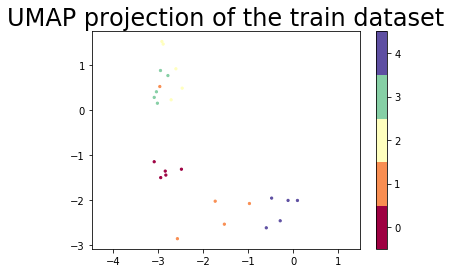

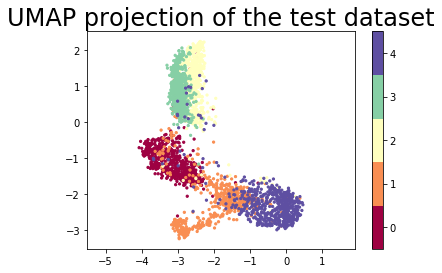

In [560]:

plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the train dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the test dataset', fontsize=24);

testing with logistic regression

In [561]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)

clf.fit(Xt1,y_train)
y_pseudo = clf.predict(Xv1)

print(accuracy_score(y_test, y_pseudo))

0.8117647058823529


Retraining with pseudo labels on original embedding

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
print(0)
clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
print(1)
y_pred = clf.predict(Xv)
print(2)

print(accuracy_score(y_test, y_pred))

In [ ]:
plt.figure(0)
plt.scatter(Xt1[:, 0], Xt1[:, 1], c=y_train, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(1)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_test, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

plt.figure(2)
plt.scatter(Xv1[:, 0], Xv1[:, 1], c=y_pred, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [ ]:
count = 0
c = 0
while count <= 5:
    while c < 100:
        c+=1
        if y_pred[i] != y_test[i]:
            plt.figure(2*i)
            plt.imshow(X_test[i])
            plt.figure(2*i + 1)
            plt.imshow(X_train[5*y_pred[i]])
            count += 1


#### Test with different k in the same n classes

In [ ]:
scores1 = []
scores2 = []
scores3 = []

kshots = [1,3, 5,10,50,100,300,500]

for k in kshots:
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k, False, tab, dico)
    
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    
    reducer = umap.UMAP(n_neighbors=12, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)
    
    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    y_test1 = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test1])
    
    ## First prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt,y_train)
    
    y_pred = clf.predict(Xv)
    scores1.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    ## Prediction with umap embedding
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(Xt1,y_train)
    
    y_pseudo = clf.predict(Xv1)
    scores2.append(accuracy_score(y_test, y_pseudo))
    
    print(accuracy_score(y_test, y_pseudo))   
    
    ## Final prediction
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500)
    clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))
    
    y_pred = clf.predict(Xv)
    scores3.append(accuracy_score(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))
    
    
plt.plot(kshots, scores1)
plt.plot(kshots, scores2)
plt.plot(kshots, scores3)

#### Generic Experiment for validation and averaging of the final score

In [ ]:
from tqdm import tqdm_notebook as tqdm
scores1 = []
scores2 = []
scores3 = []

n = 5
k = 5

for i in tqdm(range(600)):
    
    X_train, X_test, y_train, y_test, tab, dico = build_dataset(X, n, k)
    print(i)
    ## First prediction for comparison
    Xt = model.predict(X_train)
    Xv = model.predict(X_test)
    

    
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
#     clf.fit(Xt,y_train)
#     y_pred = clf.predict(Xv)
#     print(accuracy_score(y_test, y_pred))
#     a = accuracy_score(y_test, y_pred)
# #     print(a)
#     scores1.append(a)
    
    
    y_test_unsupervised = np.zeros(y_test.shape[0])-1
    y_learn = np.concatenate([y_train, y_test_unsupervised])
    
    ## Prediction with umap embedding
    reducer = umap.UMAP(n_neighbors=15, metric='cosine', n_components=20)
    embedding = reducer.fit(np.concatenate([Xt, Xv], axis=0), y_learn)

    Xt1 = embedding.transform(Xt)
    Xv1 = embedding.transform(Xv)
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.3)
    clf.fit(Xt1,y_train)
    y_pseudo = clf.predict(Xv1)
    
    print(accuracy_score(y_test, y_pseudo))
    
    a = accuracy_score(y_test, y_pseudo)
#     print(a)
    scores2.append(a)
    
    ## Final prediction
#     clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 500, C = 0.4)
#     clf.fit(np.concatenate([Xt, Xv], axis = 0),np.concatenate([y_train, y_pseudo], axis = 0))

#     y_pred = clf.predict(Xv)
#     accuracy_score(y_test, y_pred)
    
#     a = accuracy_score(y_test, y_pred)
#     print(a)
    
    scores3.append(a)
    print(np.array(scores3).mean())
    
print(np.array(scores1).mean())
print(np.array(scores2).mean())
print(np.array(scores3).mean())

In [ ]:
plt.hist(scores1, bins = 20)

In [ ]:
plt.hist(scores2, bins = 20)

In [ ]:
plt.hist(scores3, bins = 20)

In [ ]:
np.array(scores3).mean()